In [1]:
import numpy as np
import tensorflow as tf

In [21]:
def learning_hdr_gamma_correction_fn(image, mu=5000.0, clip=True):
    # http://cseweb.ucsd.edu/~viscomp/projects/SIG17HDR/
    image = tf.image.convert_image_dtype(image, tf.float32)
    mu = tf.cast(mu, dtype=tf.float32)
    if not clip:
        slope = mu / tf.log(mu+1)
        return tf.where(
            image <= 0.0,
            slope * image, tf.log(1.0 + mu * image) / tf.log(1.0 + mu))
    else:
        image = tf.clip_by_value(image, 0.0, 1.0)
        return tf.log(1.0 + mu * image) / tf.log(1.0 + mu)

In [22]:
def srgb_gamma_correction_fn(image):
    # http://www.color.org/chardata/rgb/srgb.xalter
    # Currently gradients of tf.where will be nan if one of the inputs has nan gradients
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.where(
            image <= 0.0031308, 12.92 * image,
            (1.055 * (tf.maximum(image, 0.0031308) ** (1/2.4)) - 0.055))

def reverse_srgb_gamma_correction_fn(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.where(
            image <= 0.04045, image / 12.92,
            ((tf.maximum(image, 0.04045) + 0.055) / 1.055) ** 2.4)

In [59]:
import cv2
img = cv2.imread(r'C:\Users\sky1236\Desktop\coding_everyday\prerequisite_python\archi_1920x1080.jpg')
img_tf = tf.convert_to_tensor(img/255.0, dtype=tf.float32)
# img_tf_gamma = srgb_gamma_correction_fn(img_tf)
img_tf_gamma = learning_hdr_gamma_correction_fn(img_tf, mu=500.0)

In [60]:
def quantize(image, bit_depth=8):
    max_value = 2 ** bit_depth - 1
    dtype = np.uint16 if bit_depth > 8 else np.uint8
    return np.round(np.clip(image, 0.0, 1.0) * max_value).astype(dtype)

In [61]:
with tf.Session() as sess:
    img_01 = sess.run(img_tf)
    print(np.max(img_01), np.min(img_01))
    img_gamma = sess.run(img_tf_gamma)
    cv2.imwrite(r'C:\Users\sky1236\Desktop\coding_everyday\prerequisite_python\archi_1920x1080_gamma.jpg', quantize(img_gamma, 8))

1.0 0.0


In [77]:
import matplotlib.pyplot as plt
X = np.linspace(0.0, 1.0, num=100, dtype=np.float32)
Y = np.where(
        X <= 0.0031308, 12.92 * X,
        (1.055 * (np.maximum(X, 0.0031308) ** (1/2.4)) - 0.055))
Y2 = np.where(
        X <= 0.04045, X / 12.92,
        ((np.maximum(X, 0.04045) + 0.055) / 1.055) ** 2.4)

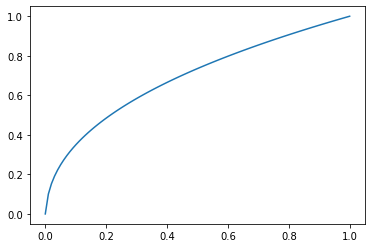

In [70]:
plt.plot(X, Y)

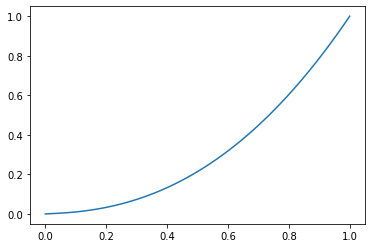

In [69]:
plt.plot(X, Y2)

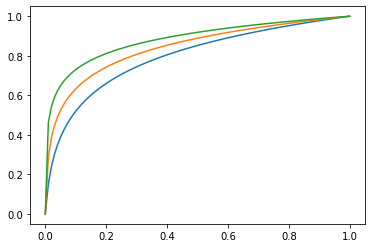

In [78]:
def func(X, mu):
    return np.log(1.0 + mu * X) / np.log(1.0 + mu)

mu_list = [100, 500, 5000]

for mu in mu_list:
    plt.plot(X, func(X, mu))
plt.show()